##Declarações

In [322]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import seaborn as sns
sns.set_style('white')

In [ ]:
from google.colab import files
arq = files.upload()

Saving master.csv to master (1).csv


##Carregando o dataset

In [323]:
import io
pontarq = io.BytesIO(arq['master.csv'])
dados = pd.read_csv(pontarq)
dados

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


##Manipulando o dataset para torná-lo mais legível e útil

In [324]:
#Vamos remover a coluna 'country-year' que, aparentemente,não faz muito sentido já que temos uma coluna 'country' e outra coluna 'year'.
dados.drop('country-year', axis=1, inplace=True)

#Renomeando as colunas para deixar com nomes mais regulares/legíveis.
dados.columns = ['country', 'year', 'sex', 'age', 'suicides_number', 'population', 'suicides_per_100k_pop', 'HDI_for_year', 'gdp_for_year($)', 'gdp_per_capita($)', 'generation']

#Estamos "corrigindo" a coluna 'age'. Somente para fins de ordenação.
dados.loc[dados.age=='5-14 years', 'age'] = '05-14 years'

#Corrigindo a coluna 'gdp_for_year($), que está como string, para um inteiro.
dados['gdp_for_year($)'] = dados['gdp_for_year($)'].apply(lambda x: int(x.replace(',', '')))

#Estamos substituindo os NaN da coluna HDI pela média de cada país
dados.set_index('country', inplace=True)
for i in sorted(dados.index.unique()):
    dados.loc[i] = dados.loc[i].fillna(dados.loc[i]['HDI_for_year'].mean())
dados.reset_index(inplace=True)

#Estamos criando uma nova coluna para saber a classe de cada país naquela ano
def classes(x):
    if x <= 1026:
        return 'baixa'
    if x <= 3996:
        return 'media-baixa'
    if x <= 12375:
        return 'media-alta'
    if x > 12375:
        return 'alta'
    return 'unknown'
dados['class'] = dados['gdp_per_capita($)'].apply(lambda x: classes(x))

dados

,country,year,sex,age,suicides_number,population,suicides_per_100k_pop,HDI_for_year,gdp_for_year($),gdp_per_capita($),generation,class
0,Albania,1987,male,15-24 years,21,312900,6.71,0.673,2156624900,796,Generation X,baixa
1,Albania,1987,male,35-54 years,16,308000,5.19,0.673,2156624900,796,Silent,baixa
2,Albania,1987,female,15-24 years,14,289700,4.83,0.673,2156624900,796,Generation X,baixa
3,Albania,1987,male,75+ years,1,21800,4.59,0.673,2156624900,796,G.I. Generation,baixa
4,Albania,1987,male,25-34 years,9,274300,3.28,0.673,2156624900,796,Boomers,baixa
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,0.675,63067077179,2309,Generation X,media-baixa
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,0.675,63067077179,2309,Silent,media-baixa
27817,Uzbekistan,2014,male,05-14 years,60,2762158,2.17,0.675,63067077179,2309,Generation Z,media-baixa
27818,Uzbekistan,2014,female,05-14 years,44,2631600,1.67,0.675,63067077179,2309,Generation Z,media-baixa


##Trabalhando com o dataset

###Quantos países temos nesse dataset?

In [325]:
#Temos 101 países, mais ou menos a metade de países existentes no mundo em 2020
dados.country.unique().size

101

###Quais as faixas etárias definidas?

In [326]:
#Faixas etárias existentes
s = sorted(dados.age.unique())
s

['05-14 years',
 '15-24 years',
 '25-34 years',
 '35-54 years',
 '55-74 years',
 '75+ years']

###Quais as gerações disponíveis?

In [327]:
#Gerações disponíveis
r = sorted(dados.generation.unique())
r
#GI 1901-1924
#Silent 1925-1942
#Boomers 1943-1964
#X 1965-1979
#Millenials 1980-2000
#Z 2001-2013

['Boomers',
 'G.I. Generation',
 'Generation X',
 'Generation Z',
 'Millenials',
 'Silent']

###Pego por ano o maior e o menor gdp per capita e comparada a taxa de suicídio

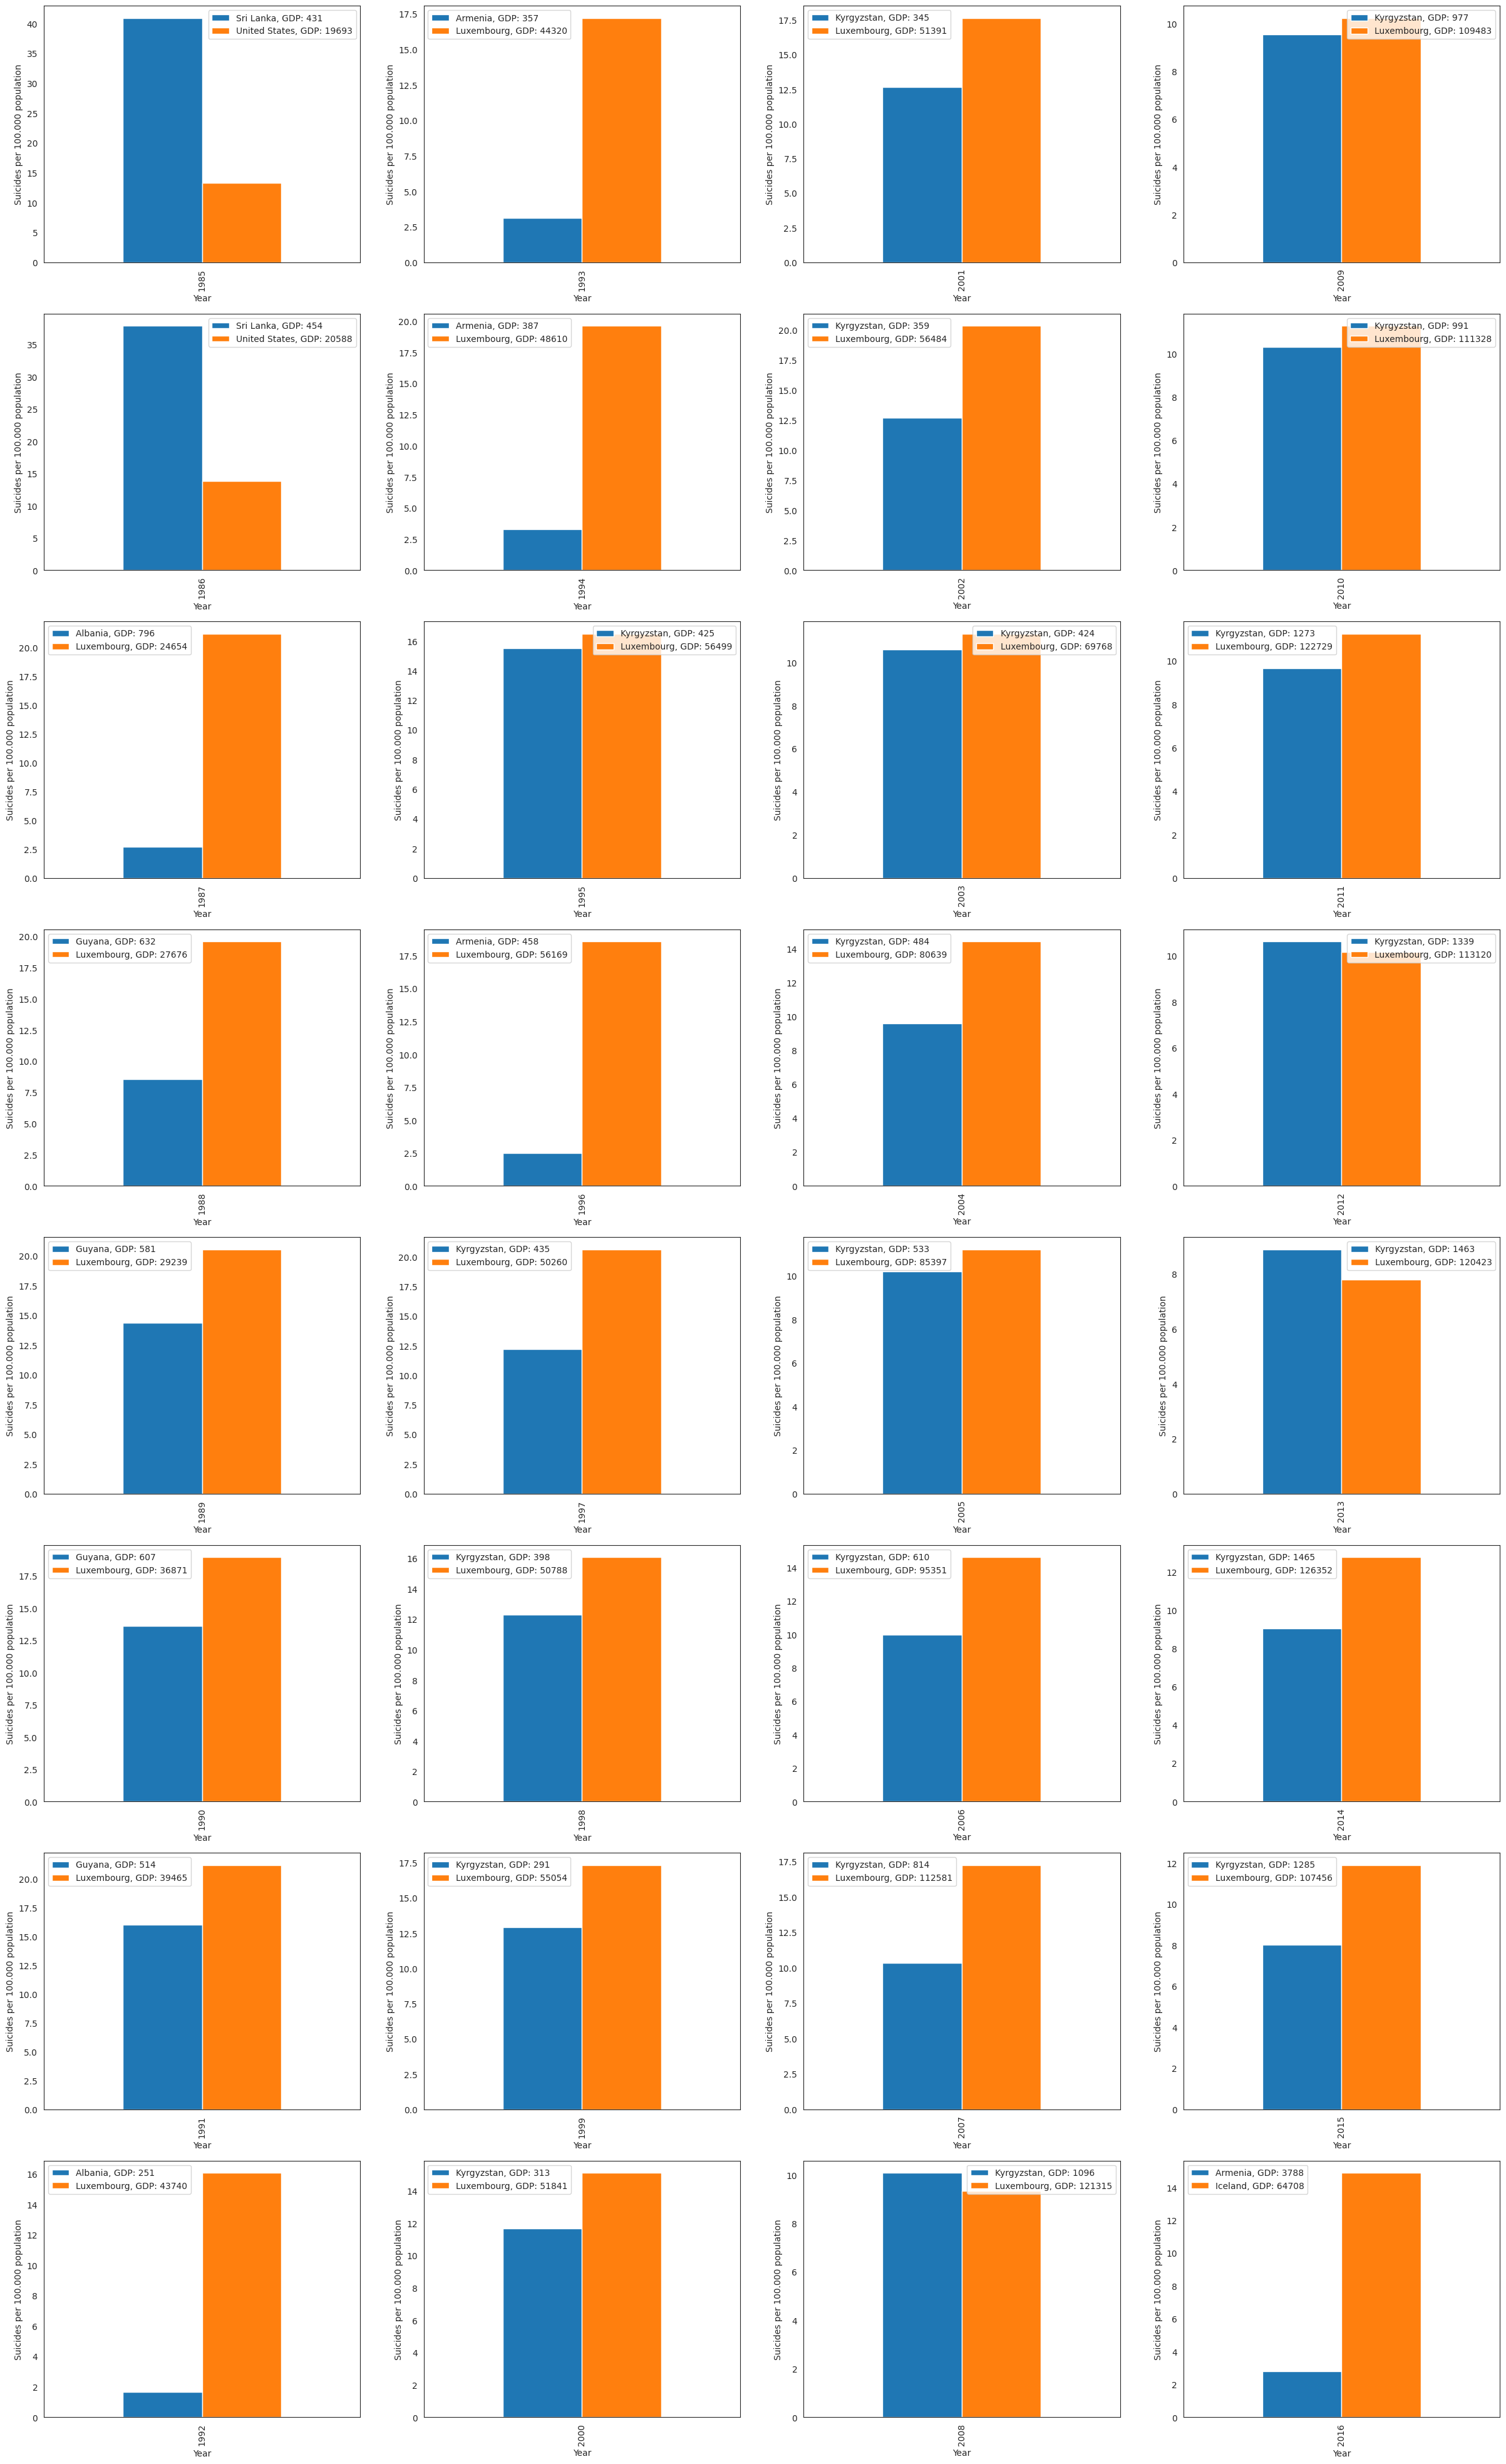

In [328]:
#Agrupando por ano, gdp per capita e país
x = dados[['country', 'year', 'suicides_number', 'population', 'gdp_per_capita($)']].groupby(['year', 'gdp_per_capita($)', 'country']).sum()

#Refazendo a taxa de suicídio
y = x.iloc[:]['suicides_number']/(x.iloc[:]['population']/100000)

#Definição das variáveis relacionadas com os gráficos
l, c = 8, 4
fig, plt1 = subplots(l, c, figsize=(30,50))
j, k = 0, 0

#lista que armazenará o maior e menor gdp per capita
d = []

for i in range(1985, 2016+1):
    #Guarda o nome do país com menor e maior gpd per capita, respectivamente
    a = [y.loc[i].index[0][1], y.loc[i].index[y.loc[i].size-1][1]]
    #Guarda o gdp per capita dos países acima
    b = [y.loc[i].iloc[0], y.loc[i].iloc[y.loc[i].size-1]]

    d.extend([b])

    #Cria um dataframe com os dados de 'a' e 'b' para plotar
    z = pd.DataFrame({a[0]+', GDP: '+str(y.loc[i].index[0][0]):[b[0]], a[1]+', GDP: '+str(y.loc[i].index[y.loc[i].size-1][0]):[b[1]]}, index=[i])
    z.plot.bar(ax=plt1[j][k], xlabel = 'Year', ylabel='Suicides per 100.000 population')

    #Controle para a região de plotagem
    j += 1
    if j > l-1:
        j, k = 0, k + 1
    if k > c-1:
        k = 0


####Porcentagem em que países com maior e menor gdp per capita aparecem com a maior taxa de suicídio

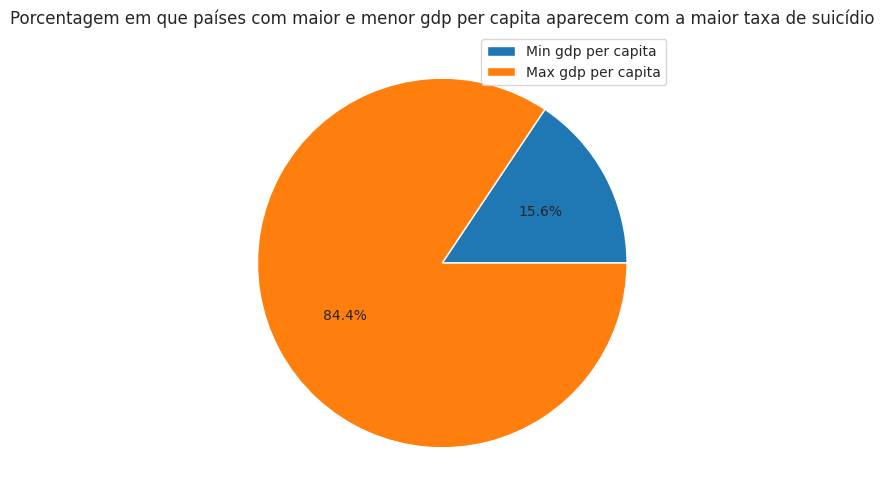

In [329]:
d = pd.DataFrame(d)

#Contando as vezes em que o país com maior e menor gdp per capita aparecem com a maior taxa de suicídio
maxx, minn = (d[0] < d[1]).sum(), (d[0] > d[1]).sum()

fig1, ax1 = subplots(figsize=(6, 6))
ax1.pie([minn, maxx], autopct='%0.1f%%')
ax1.legend(['Min gdp per capita', 'Max gdp per capita'])
ax1.set_title('Porcentagem em que países com maior e menor gdp per capita aparecem com a maior taxa de suicídio')
show()

###Pego por ano o maior e o menor gdp por ano e comparada a taxa de suicídio

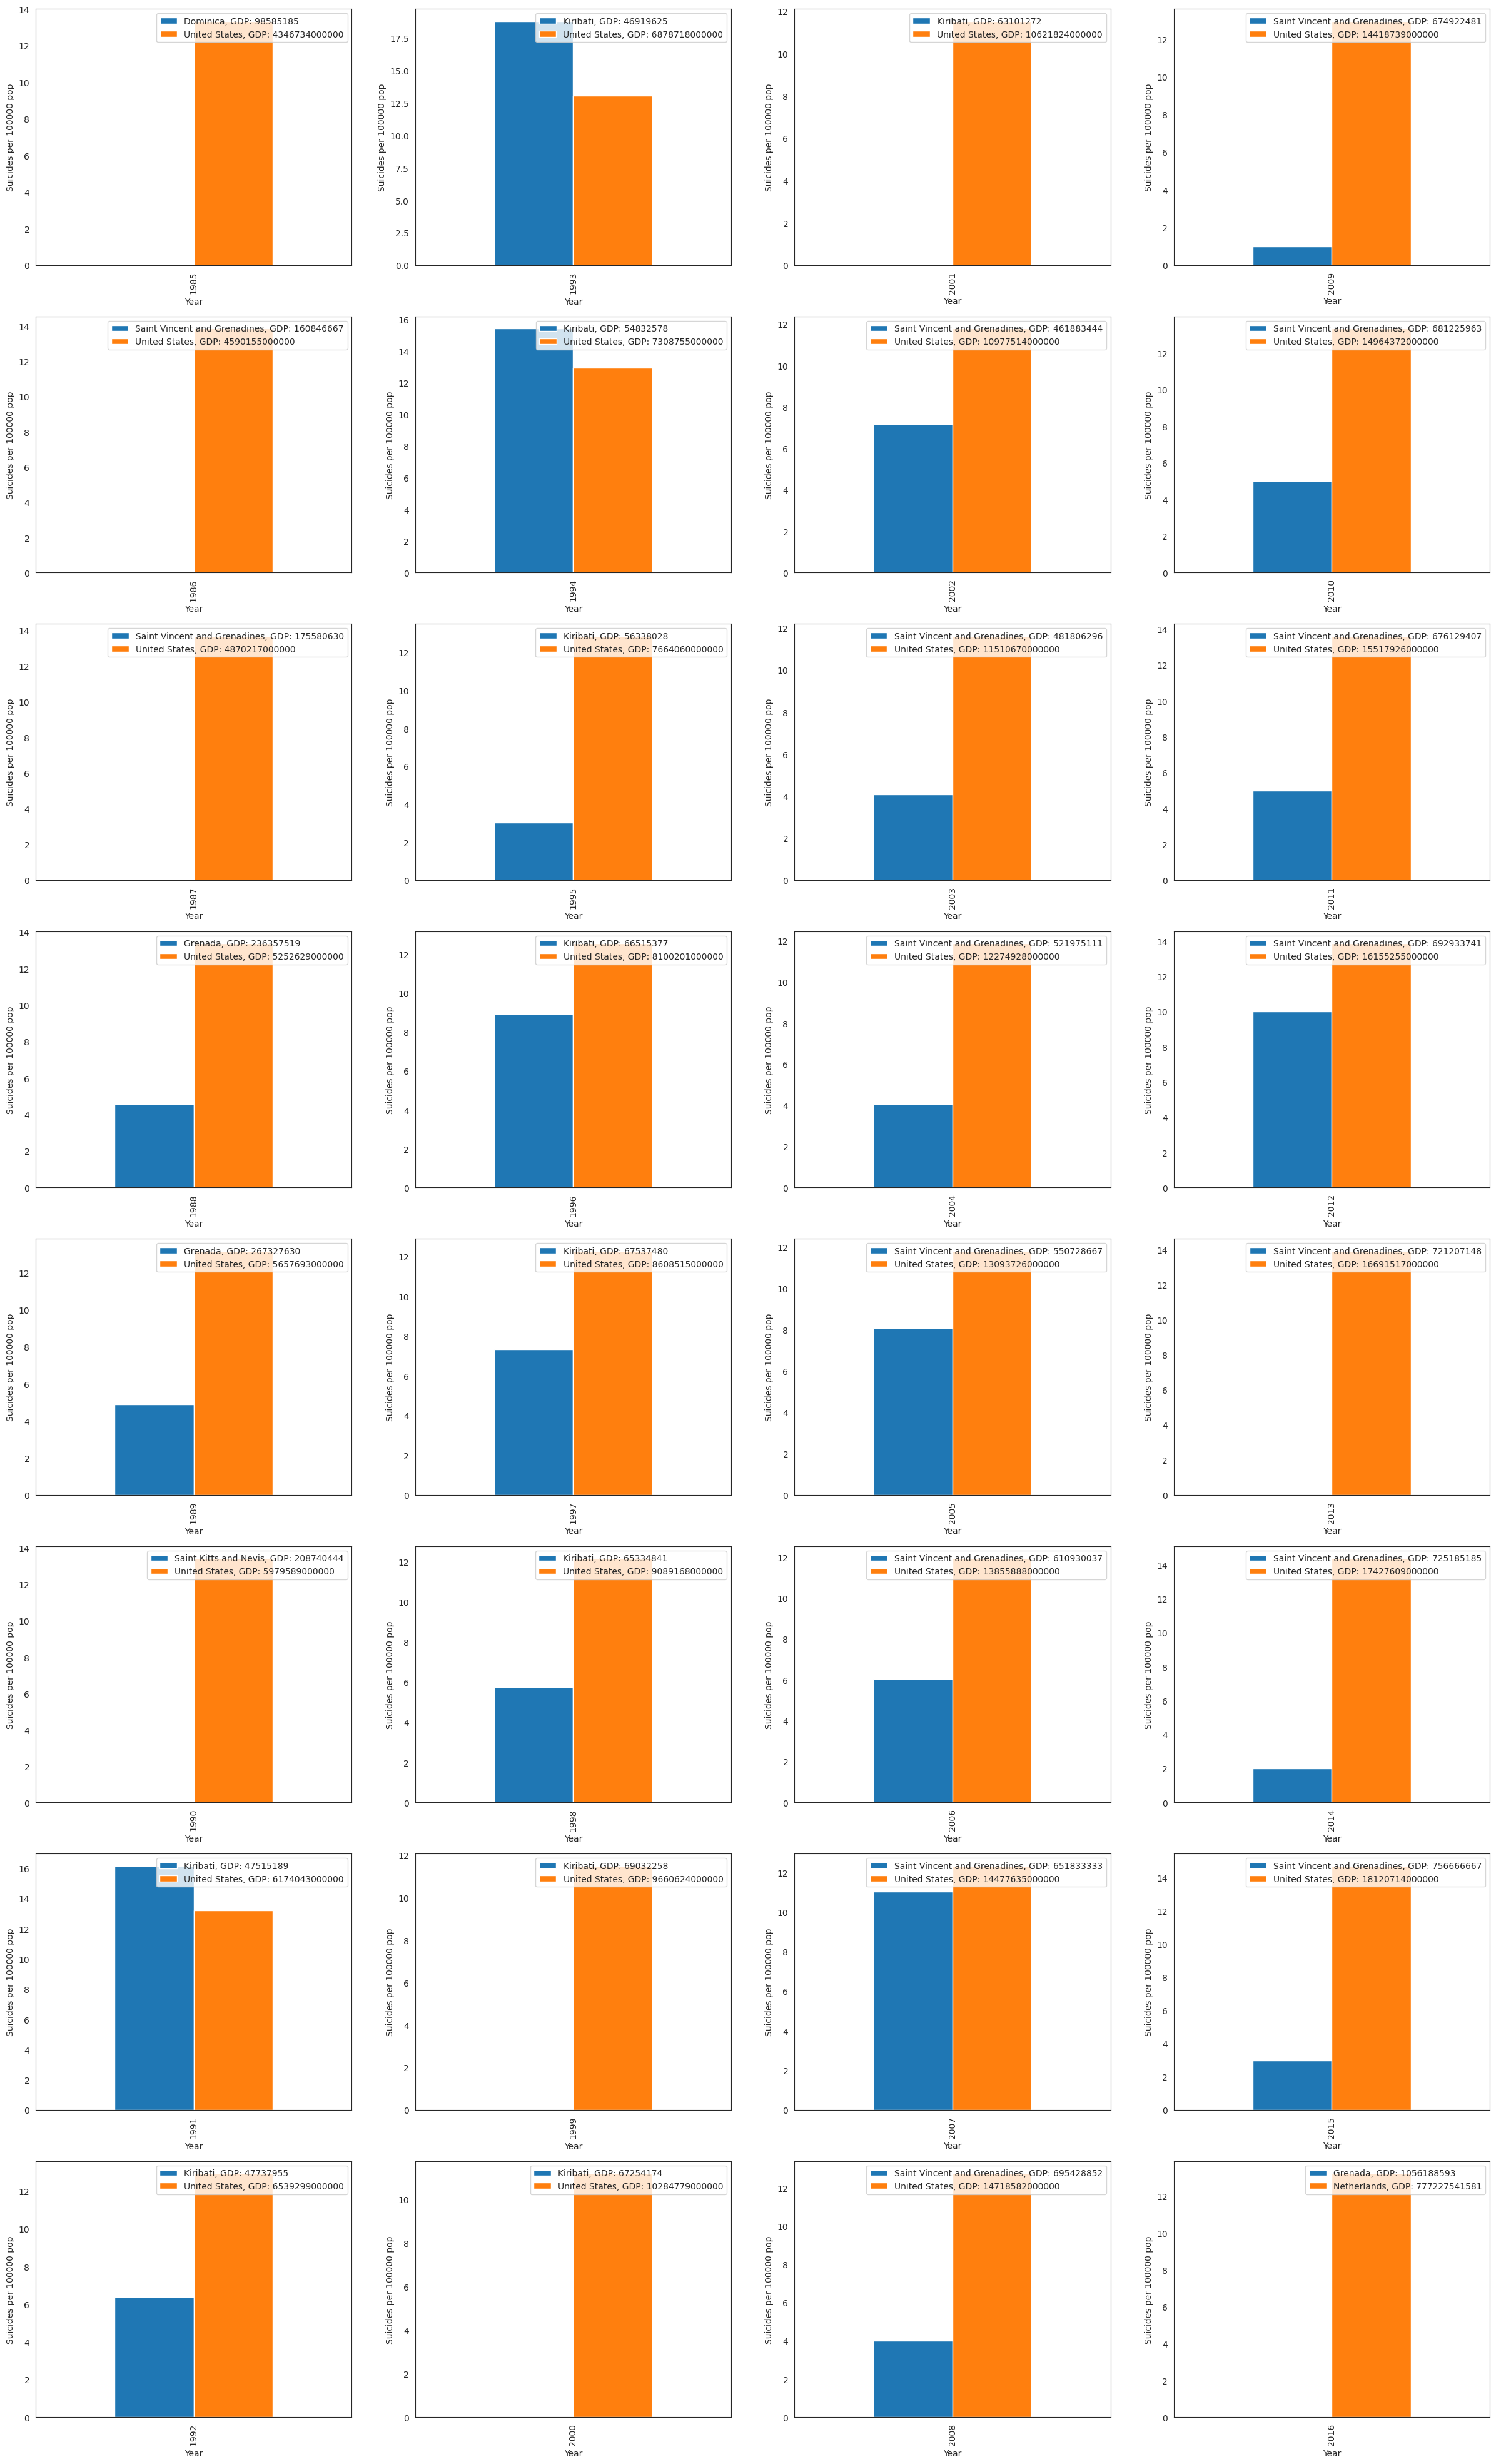

In [330]:
#Agrupando por ano, gdp for year e país
x = dados[['country', 'year', 'suicides_number', 'population', 'gdp_for_year($)']].groupby(['year', 'gdp_for_year($)', 'country']).sum()
#Refazendo a taxa de suicídio
y = x.iloc[:]['suicides_number']/(x.iloc[:]['population']/100000)

#Definição das variáveis relacionadas com os gráficos
l, c = 8, 4
fig, plt1 = subplots(l, c, figsize=(30,50))
j, k = 0, 0

#lista que armazenará o maior e menor gdp for year
d = []

for i in range(1985, 2016+1):
    #Guarda o nome do país com menor e maior gpd for year, respectivamente
    a = [y.loc[i].index[0][1], y.loc[i].index[y.loc[i].size-1][1]]
    #Guarda o gdp for year dos países acima
    b = [y.loc[i].iloc[0], y.loc[i].iloc[y.loc[i].size-1]]

    d.extend([b])

    #Cria um dataframe com os dados de 'a' e 'b' para plotar
    z = pd.DataFrame({a[0]+', GDP: '+str(y.loc[i].index[0][0]):[b[0]], a[1]+', GDP: '+str(y.loc[i].index[y.loc[i].size-1][0]):[b[1]]}, index=[i])
    z.plot.bar(ax=plt1[j][k], xlabel = 'Year', ylabel='Suicides per 100000 pop')
    
    #Controle para a região de plotagem
    j += 1
    if j > l-1:
        j, k = 0, k + 1
    if k > c-1:
        k = 0

####Porcentagem em que países com maior e menor gdp por ano aparecem com a maior taxa de suicídio

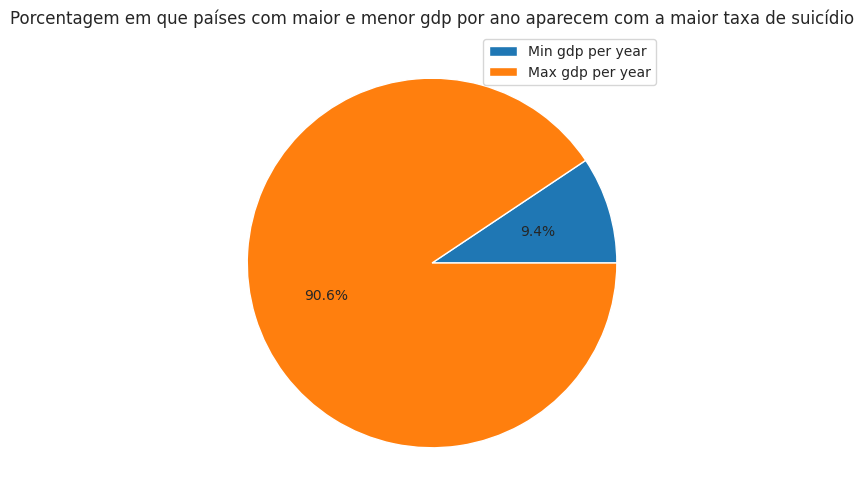

In [331]:
d = pd.DataFrame(d)

#Contando as vezes em que o país com maior e menor gdp per capita aparecem com a maior taxa de suicídio
maxx, minn = (d[0] < d[1]).sum(), (d[0] > d[1]).sum()

fig1, ax1 = subplots(figsize=(6, 6))
ax1.pie([minn, maxx], autopct='%0.1f%%')
ax1.legend(['Min gdp per year', 'Max gdp per year'])
ax1.set_title('Porcentagem em que países com maior e menor gdp por ano aparecem com a maior taxa de suicídio')
show()

###Gráfico que mostra o número de suicídios total em relação ao HDI

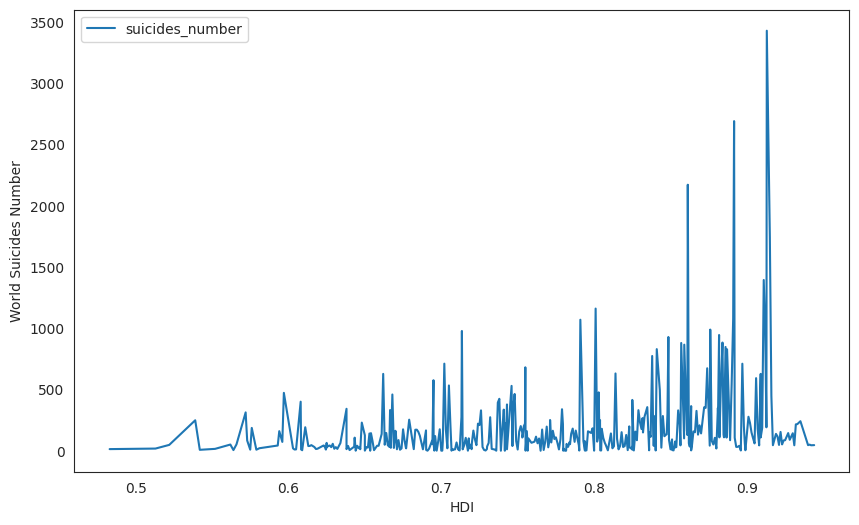

In [332]:
fig, plt = subplots(1, 1, figsize=(10,6))

x = pd.pivot_table(dados, index=['HDI_for_year'], values=['suicides_number'])

lixo = x.plot(ax=plt, xlabel='HDI', ylabel='World Suicides Number')

####No gráfico acima não conseguimos ver, com clareza, se os dados estão relacionados entre sí, ou seja, se quanto maior o HDI maior o número de suicídios. Com um gráfico de dispersão podemos ver  um pouco melhor.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


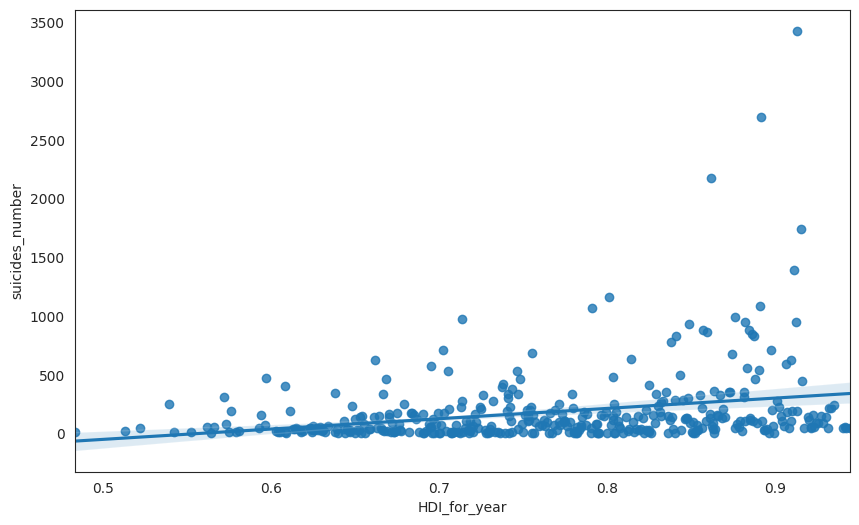

In [333]:
fig, plt = subplots(1, 1, figsize=(10,6))
x.reset_index(inplace=True)
lixo = sns.regplot(x['HDI_for_year'], x['suicides_number'], data=x, ax=plt)

###Que gerações mais se suicidarm por faixa etária?

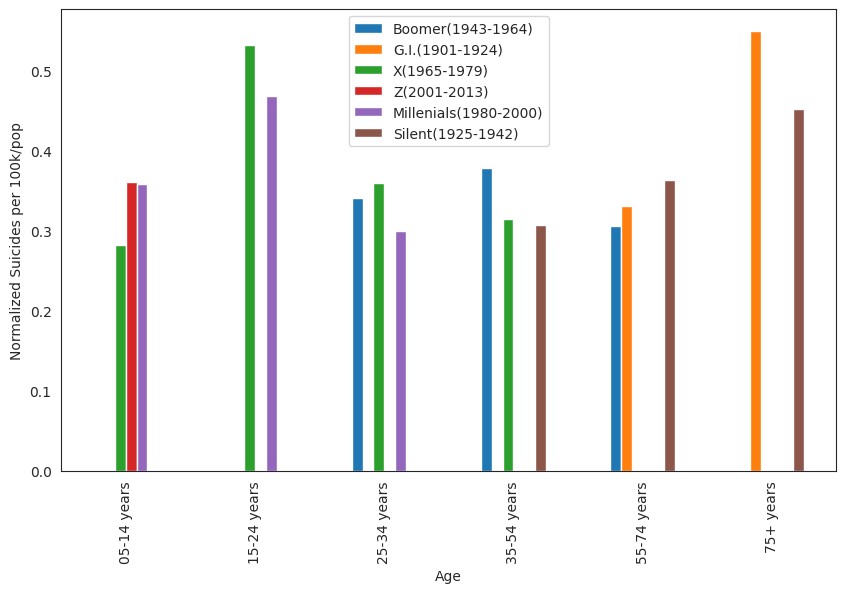

In [334]:
fig, plt1 = subplots(1, 1, figsize=(10,6))

z = pd.pivot_table(dados, index=['age'], columns=['generation'], values=['suicides_per_100k_pop'])
z.fillna(0, inplace=True)
w = z.div(z.sum(1), axis=0)

w.columns = ['Boomer(1943-1964)', 'G.I.(1901-1924)', 'X(1965-1979)', 'Z(2001-2013)', 'Millenials(1980-2000)', 'Silent(1925-1942)']
lixo = w.plot.bar(ax=plt1, xlabel='Age', ylabel='Normalized Suicides per 100k/pop')

###Frequência das taxas de suicídio

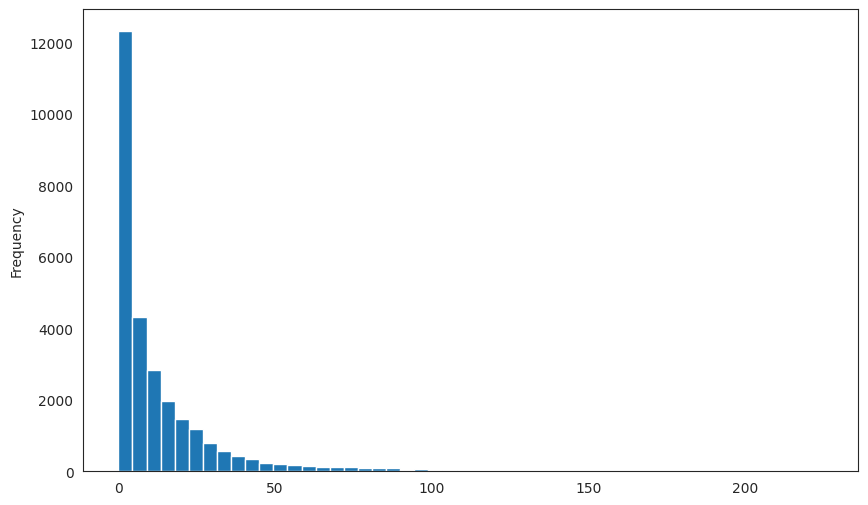

In [335]:
fig, plt1 = subplots(1, 1, figsize=(10,6))
lixo = dados['suicides_per_100k_pop'].plot.hist(bins=50, ax=plt1)

###Suicídios no Brasil

####Número de suícidios no Brasil

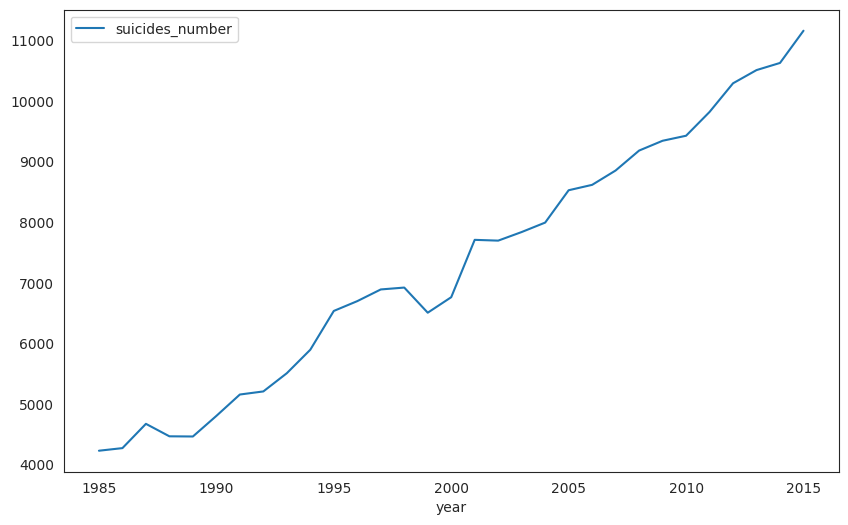

In [336]:
fig, plt = subplots(1, 1, figsize=(10,6))
brasil = dados[dados.country=='Brazil']
lixo = brasil[['year', 'suicides_number']].groupby(['year']).sum().plot(ax=plt)

#####Número de suicídios por sexo no Brasil

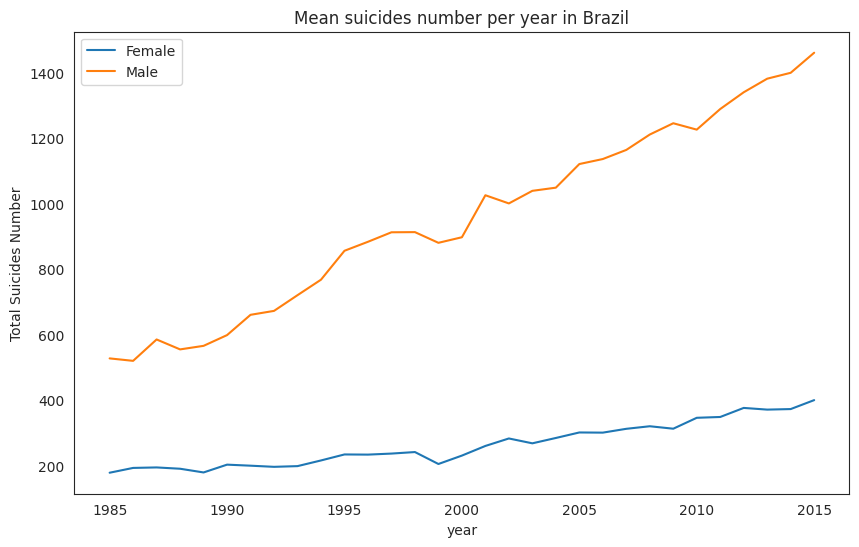

In [361]:
fig, plt1 = subplots(1, 1, figsize=(10,6))
x = brasil[['year', 'suicides_number', 'sex']].groupby(['sex', 'year']).mean().suicides_number
lixo = pd.DataFrame({'Female':x['female'], 'Male':x['male']}).plot(ax=plt1, ylabel='Total Suicides Number', title='Mean suicides number per year in Brazil')

####Porcentagem de suicídios por sexo no Brasil

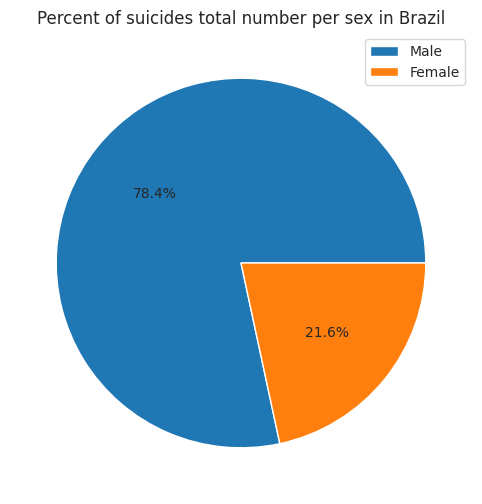

In [340]:
male = dados[(dados.country=='Brazil') & (dados.sex=='male')].suicides_number.sum()
female = dados[(dados.country=='Brazil') & (dados.sex=='female')].suicides_number.sum()
fig1, ax1 = subplots(figsize=(10, 6))
ax1.pie([male, female], autopct='%0.1f%%')
ax1.legend(['Male', 'Female'])
ax1.set_title('Percent of suicides total number per sex in Brazil')
show()

####Número total de suicídos do sexo masculino no Brasil por faixa etária

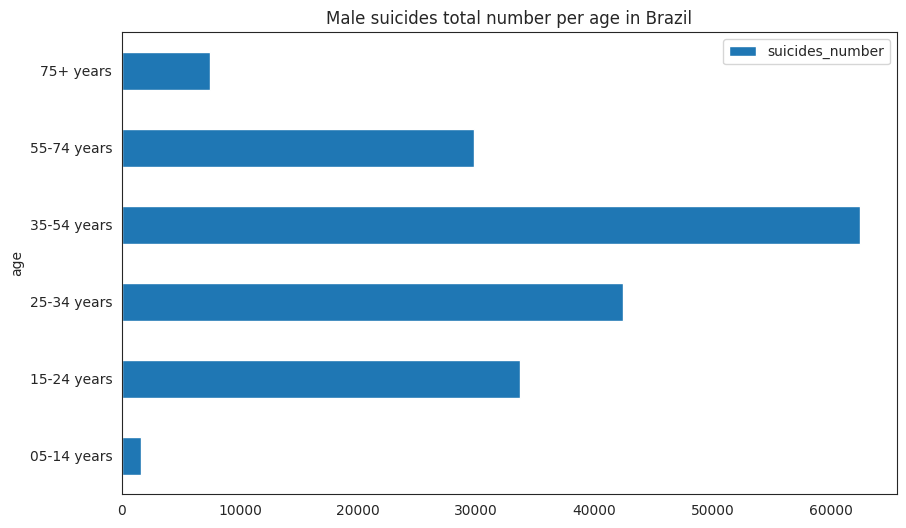

In [342]:
fig, plt = subplots(1, 1, figsize=(10,6))
lixo = dados[(dados.country=='Brazil') & (dados.sex=='male')][['age', 'suicides_number']].groupby(['age']).sum().plot.barh(title='Male suicides total number per age in Brazil', ax=plt)

####Número total de suicídios masculinos no Brasil por classe

In [343]:
x = dados[(dados.country=='Brazil') & (dados.sex=='male')]
y = pd.pivot_table(x, index=['age'], values=['suicides_number'], columns=['class'], aggfunc=np.sum)
y

suicides_number                       
class                  alta media-alta media-baixa
age                                               
05-14 years             298        729         603
15-24 years            5323      15376       13021
25-34 years            7823      19305       15341
35-54 years           11742      29322       21436
55-74 years            5789      13907       10148
75+ years              1488       3478        2469

#####Podemos ver nesse gráfico que a classe onde mais ocorreram suicídios no Brasil foi média-alta. Porém devemos levar em consideração a quantidade de anos em que o país esteve em cada classe.

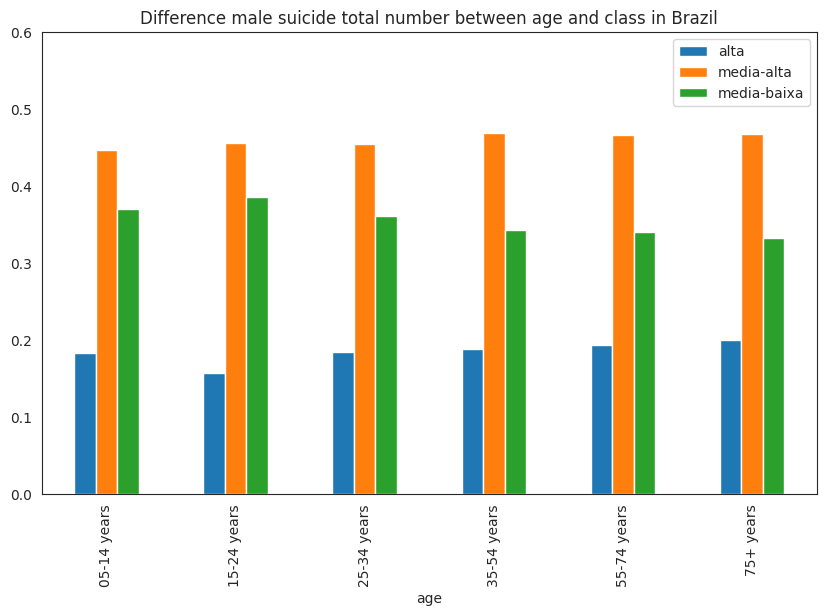

In [344]:
y.columns = ['alta', 'media-alta', 'media-baixa']
fig, plt = subplots(1, 1, figsize=(10,6))
w = y.loc[:].div(y.loc[:].sum(1), axis=0)
lixo = w.plot.bar(ax=plt, ylim=[0.0, 0.6], title='Difference male suicide total number between age and class in Brazil')

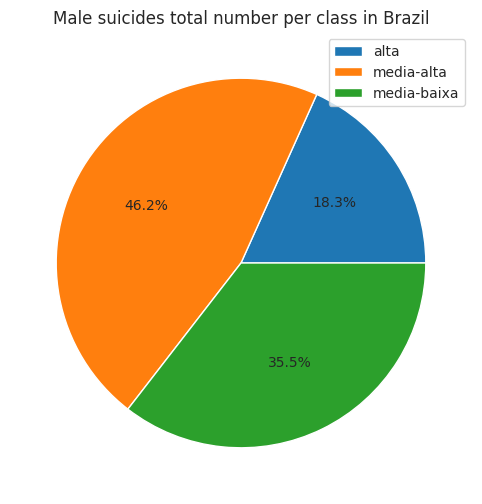

In [345]:
fig1, ax1 = subplots(figsize=(10, 6))
ax1.pie(y.sum().values, autopct='%0.1f%%')
ax1.legend(y.sum().index)
ax1.set_title('Male suicides total number per class in Brazil')
show()

####Número médio de suicídios masculinos no Brasil por classe

In [346]:
x = dados[(dados.country=='Brazil') & (dados.sex=='male')]
y = pd.pivot_table(x, index=['age'], values=['suicides_number'], columns=['class'], aggfunc=np.mean) #Assim eu vou tar somente fazendo a média, e eu quero a média dos anos
y

suicides_number                          
class                  alta   media-alta  media-baixa
age                                                  
05-14 years           74.50    56.076923    43.071429
15-24 years         1330.75  1182.769231   930.071429
25-34 years         1955.75  1485.000000  1095.785714
35-54 years         2935.50  2255.538462  1531.142857
55-74 years         1447.25  1069.769231   724.857143
75+ years            372.00   267.538462   176.357143

#####Podemos ver nesse gráfico que a classe onde mais ocorreram suicídios no Brasil foi alta.

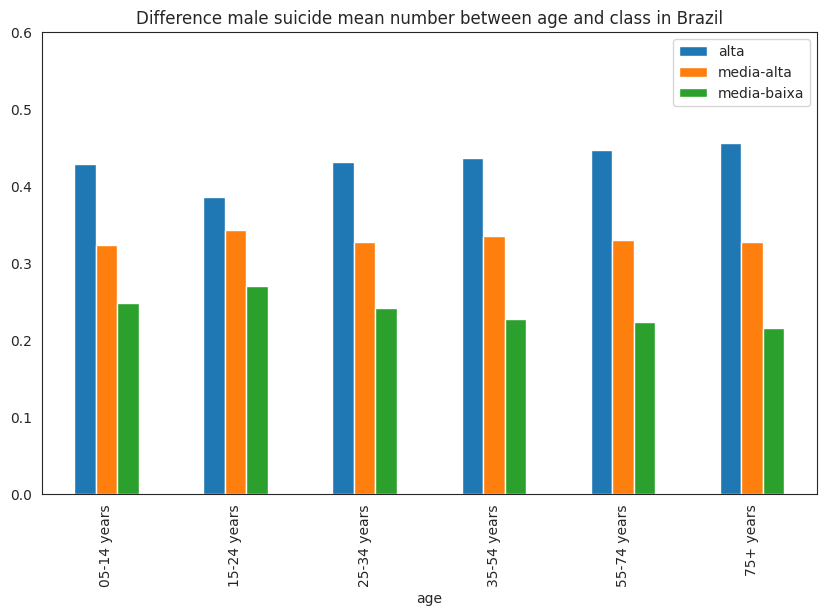

In [347]:
y.columns = ['alta', 'media-alta', 'media-baixa']
fig, plt = subplots(1, 1, figsize=(10,6))
w = y.loc[:].div(y.loc[:].sum(1), axis=0)
lixo = w.plot.bar(ax=plt, ylim=[0.0, 0.6], title='Difference male suicide mean number between age and class in Brazil')

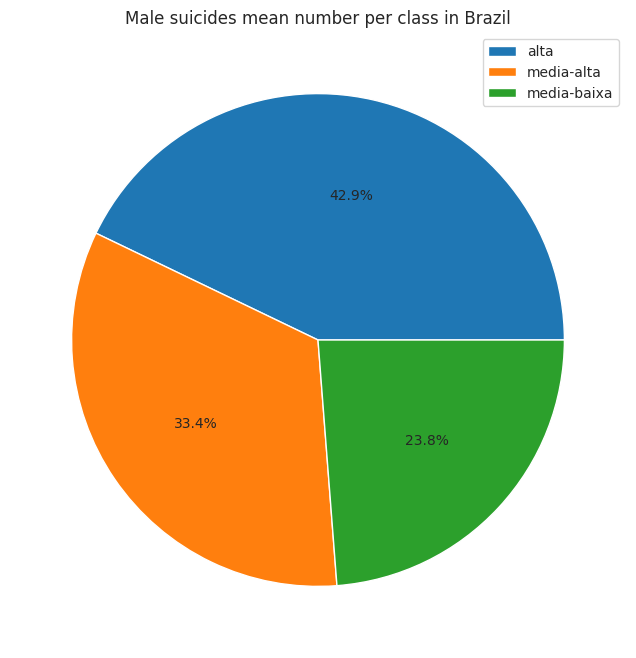

In [348]:
fig1, ax1 = subplots(figsize=(8, 8))
ax1.pie(y.sum().values, autopct='%0.1f%%')
ax1.legend(y.sum().index)
ax1.set_title('Male suicides mean number per class in Brazil')
show()

####Gráfico de correlação entre o número de suicídios e o número de gdp per capita

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


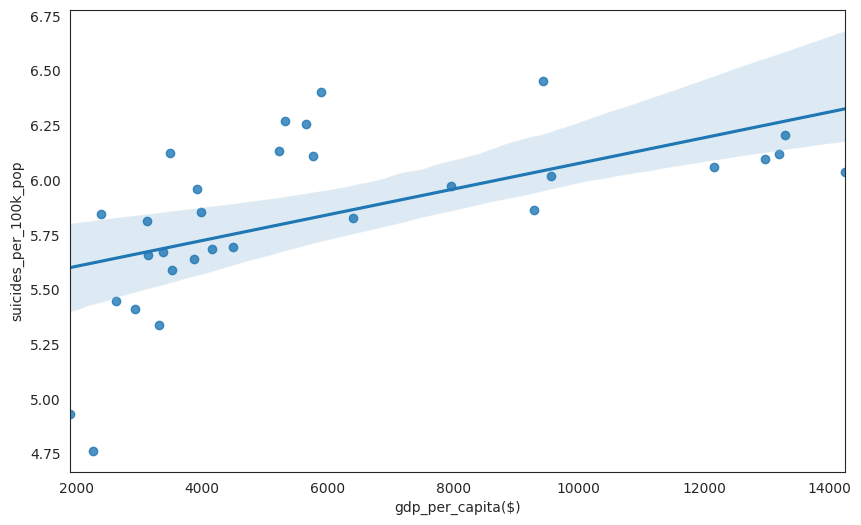

In [350]:
fig, plt = subplots(1, 1, figsize=(10,6))
x = pd.pivot_table(dados[dados.country=='Brazil'], index=['gdp_per_capita($)'], values=['suicides_per_100k_pop']).reset_index()
lixo = sns.regplot(x['gdp_per_capita($)'], x['suicides_per_100k_pop'], ax=plt)

###Média da taxa de suicídios por sexo  no mundo

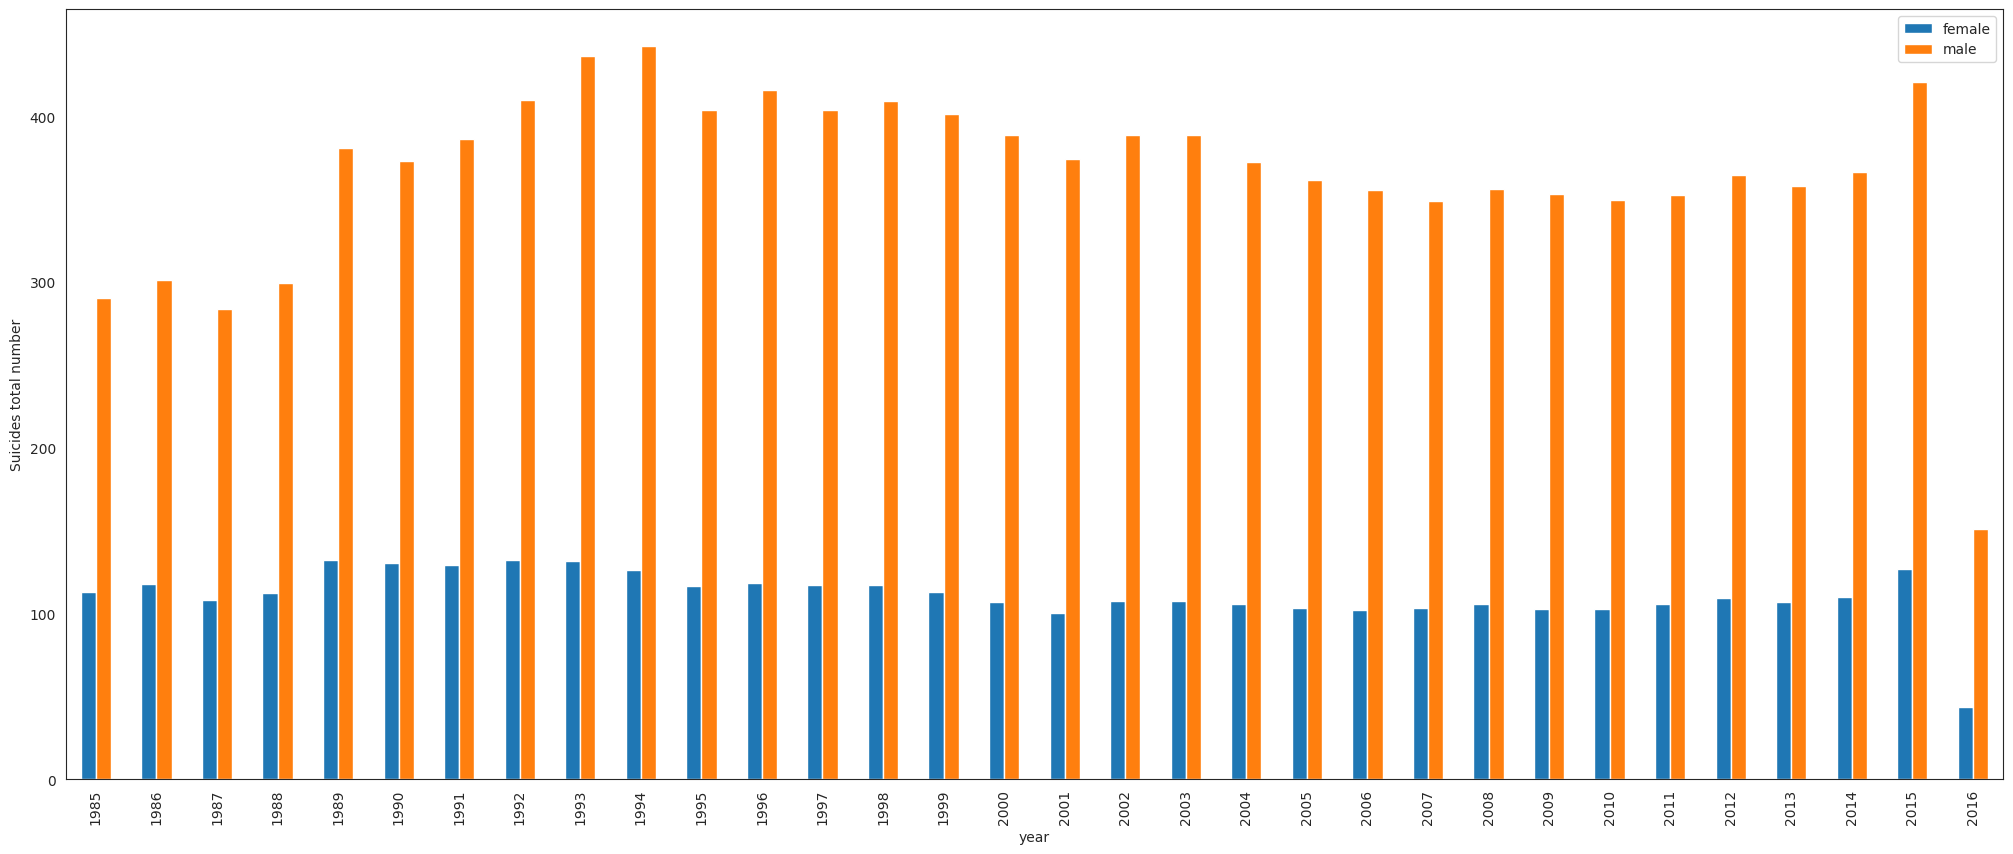

In [356]:
fig, plt1 = subplots(1, 1, figsize=(25,10))
x = pd.pivot_table(dados, index=['year'], columns=['sex'], values=['suicides_number'], aggfunc=np.mean)
x.columns=['female', 'male']
lixo = x.plot.bar(ax=plt1, ylabel='Suicides total number')

###Porcentagem de suicídios por sexo no mundo

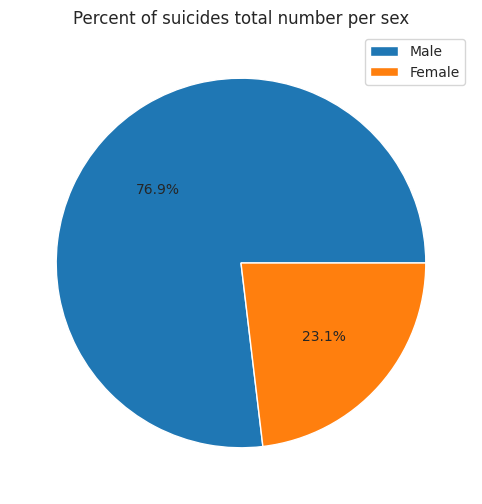

In [357]:
male = dados[dados.sex=='male'].suicides_number.sum()
female = dados[dados.sex=='female'].suicides_number.sum()
fig1, ax1 = subplots(figsize=(10, 6))
ax1.pie([male, female], autopct='%0.1f%%')
ax1.legend(['Male', 'Female'])
ax1.set_title('Percent of suicides total number per sex')
show()

###Número de suicídios por sexo no mundo

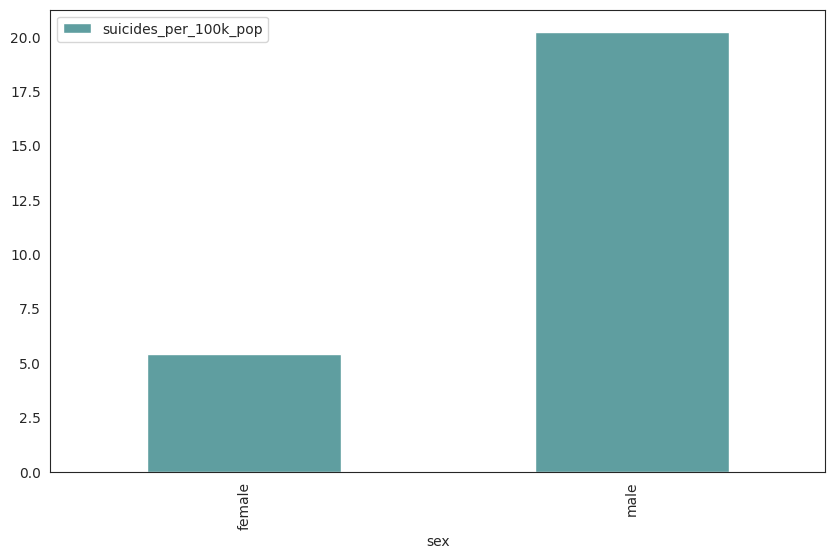

In [358]:
fig, plt = subplots(1, 1, figsize=(10,6))
lixo = dados[['sex', 'suicides_per_100k_pop']].groupby('sex').mean().plot.bar(color='cadetblue', ax=plt)

###Número de suicídios por classe no mundo

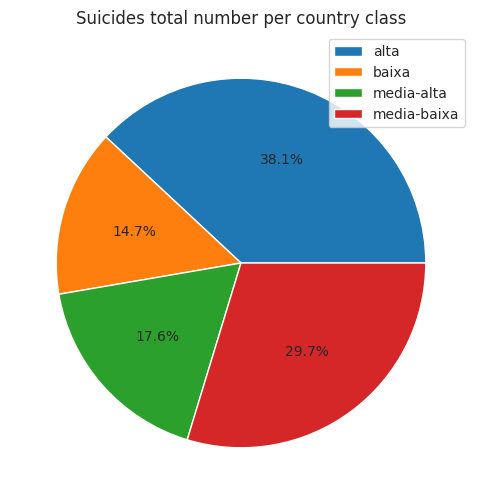

In [360]:
fig1, ax1 = subplots(figsize=(10, 6))
ax1.pie(x.suicides_number, autopct='%0.1f%%')
ax1.legend(x.index)
ax1.set_title('Suicides total number per country class')
show()

###Extras

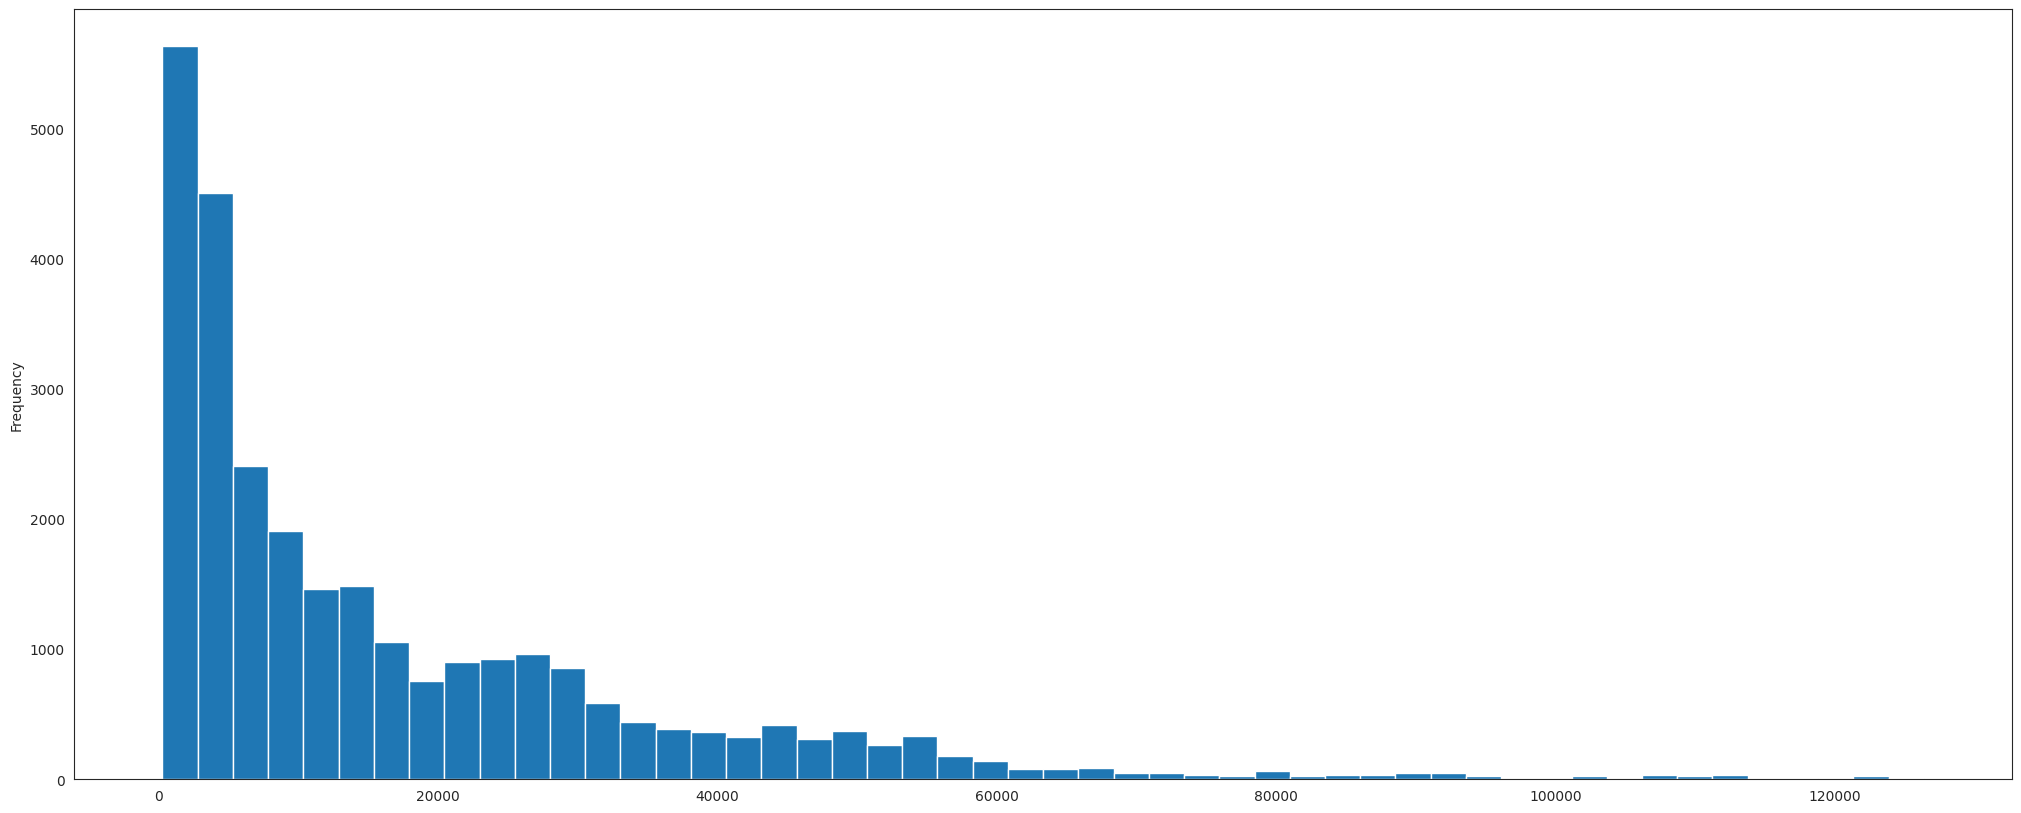

In [303]:
fig, plt1 = subplots(1, 1, figsize=(25,10))
lixo = dados['gdp_per_capita($)'].plot.hist(bins=50, ax=plt1)
show()

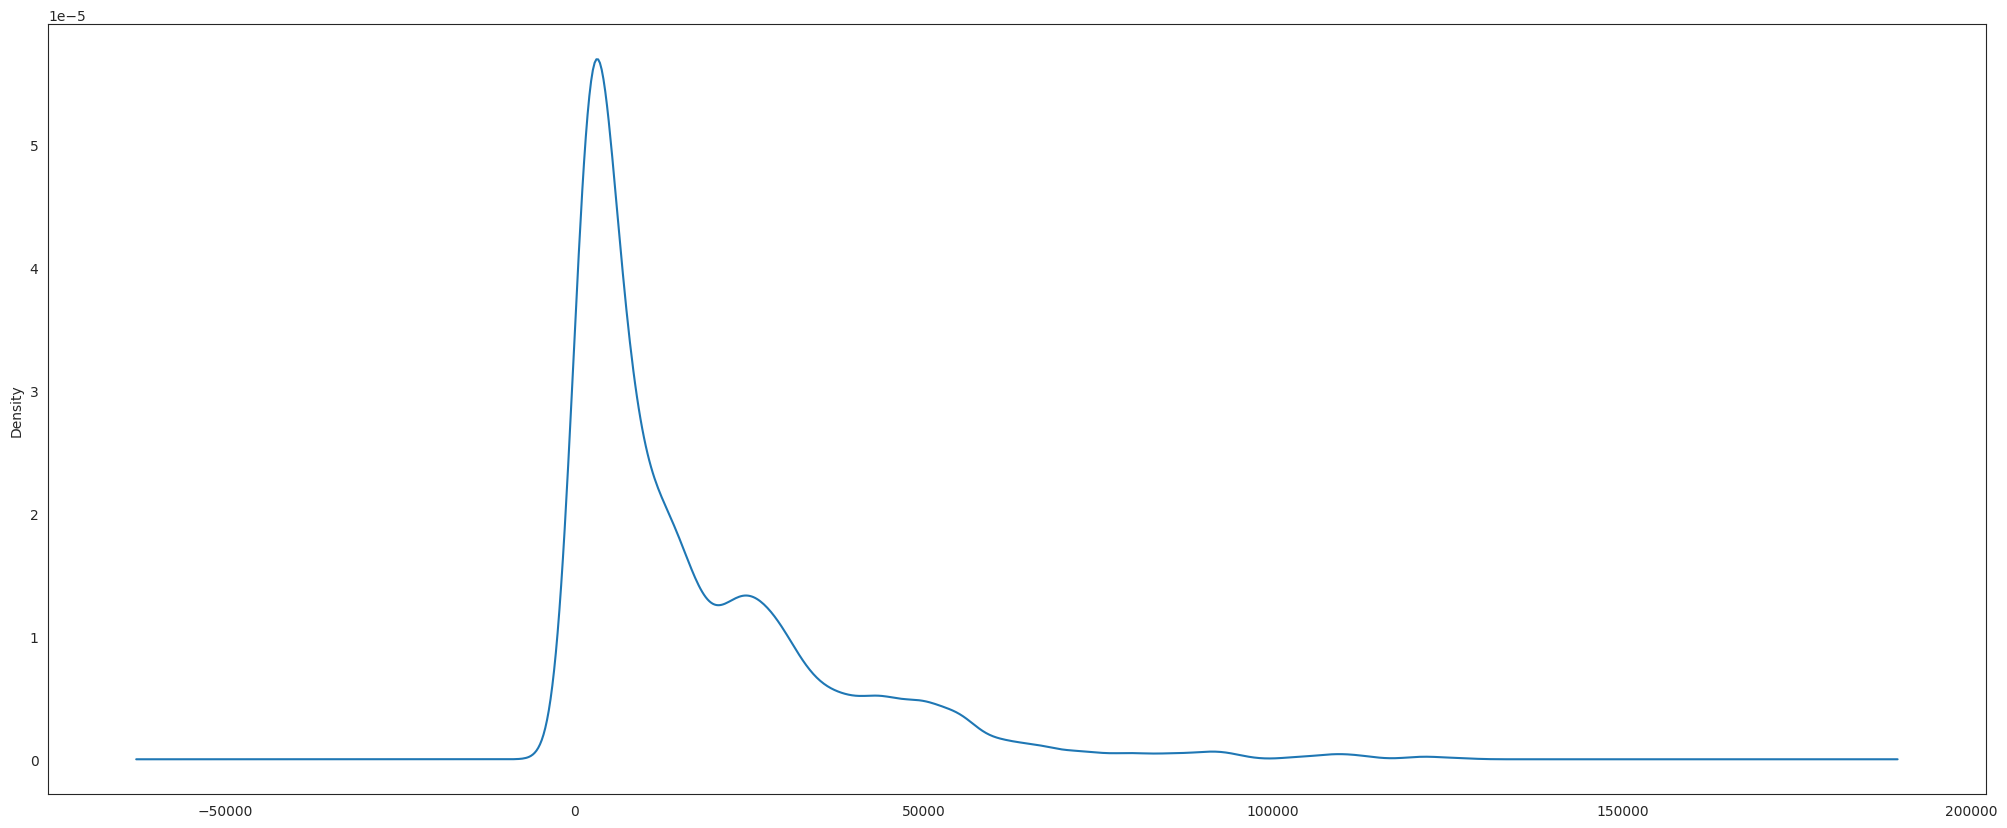

In [304]:
fig, plt1 = subplots(1, 1, figsize=(25,10))
lixo = dados['gdp_per_capita($)'].plot.density(ax=plt1)

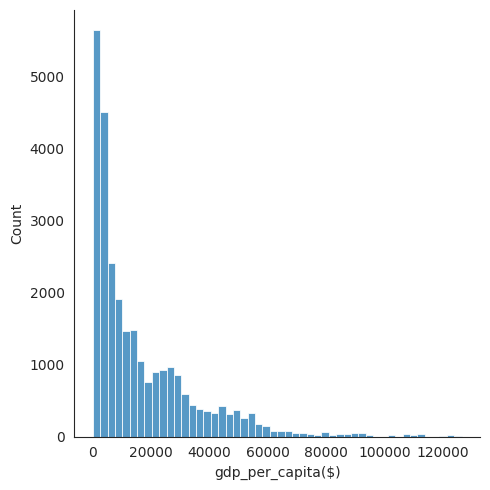

In [307]:
lixo = sns.displot(dados['gdp_per_capita($)'], bins=50)

####Número de suicídios por classe no mundo

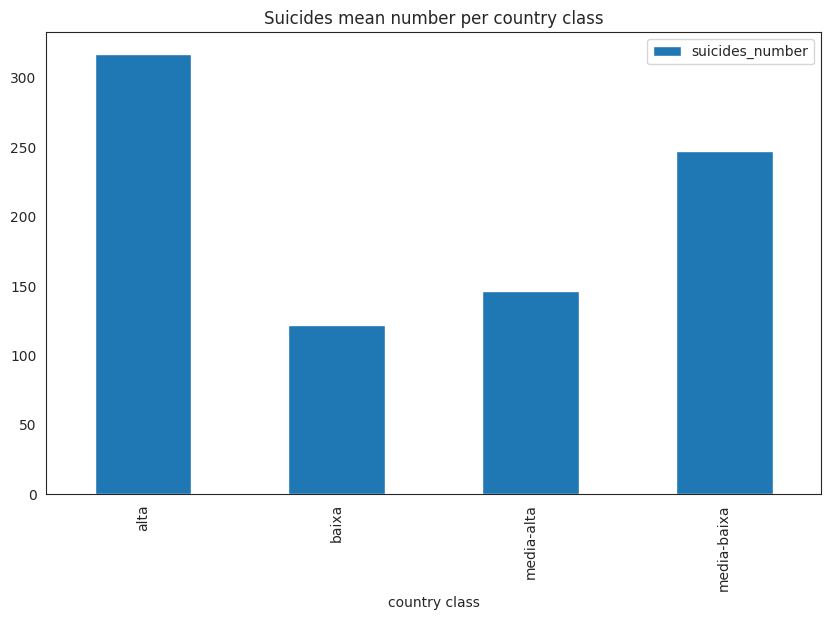

In [359]:
fig, plt = subplots(1, 1, figsize=(10,6))
x = pd.pivot_table(dados, index=['class'], values=['suicides_number'], aggfunc=np.mean)
lixo = x.plot.bar(xlabel='country class', title = 'Suicides mean number per country class', ax=plt)